In [1]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# 数据维度的调整：N H W C
train_images = np.reshape(train_images,(train_images.shape[0],train_images.shape[1],train_images.shape[2],1))
test_images = np.reshape(test_images,(test_images.shape[0],test_images.shape[1],test_images.shape[2],1))

In [3]:
def get_train(size):
    index = np.random.randint(0, np.shape(train_images)[0], size)
    resized_images = tf.image.resize_with_pad(train_images[index],224,224,)

    return resized_images.numpy(), train_labels[index]

def get_test(size):
    index = np.random.randint(0, np.shape(test_images)[0], size)
    resized_images = tf.image.resize_with_pad(test_images[index],224,224,)
    
    return resized_images.numpy(), test_labels[index]

In [4]:
class Inception(tf.keras.layers.Layer):
    # 设置模块的构成
    def __init__(self,c1,c2,c3,c4):
        super().__init__()
        # 线路1:1*1 RELU same c1
        self.p1_1 = tf.keras.layers.Conv2D(c1,kernel_size=1,activation="relu",padding ="same")
        # 线路2:1*1 RELU same c2[0]
        self.p2_1 = tf.keras.layers.Conv2D(c2[0],kernel_size=1,activation="relu",padding="same")
        # 线路2:3*3 RELU same c2[1]
        self.p2_2 = tf.keras.layers.Conv2D(c2[1],kernel_size=3,activation="relu",padding='same')
        # 线路3:1*1 RELU same c3[0]
        self.p3_1 = tf.keras.layers.Conv2D(c3[0],kernel_size=1,activation="relu",padding="same")
        # 线路3:5*5 RELU same c3[1]
        self.p3_2 = tf.keras.layers.Conv2D(c3[1],kernel_size=5,activation="relu",padding='same')
        # 线路4: max-pool 
        self.p4_1 = tf.keras.layers.MaxPool2D(pool_size=3,padding="same",strides=1)
        # 线路4:1*1
        self.p4_2 = tf.keras.layers.Conv2D(c4,kernel_size=1,activation="relu",padding="same")
    # 前行传播过程
    def call(self,x):
        # 线路1
        p1 = self.p1_1(x)
        # 线路2
        p2 = self.p2_2(self.p2_1(x))
        # 线路3
        p3 = self.p3_2(self.p3_1(x))
        # 线路4
        p4 = self.p4_2(self.p4_1(x))
        # concat
        outputs = tf.concat([p1,p2,p3,p4],axis=-1)
        return outputs

In [5]:
Inception(64,(96,128),(16,32),32)

In [6]:
# 用于B5, 辅助分类器
def aux_classifier(x,filter_size):
    # 池化层
    x = tf.keras.layers.AveragePooling2D(pool_size=5,strides = 3,padding='same')(x)
    # 卷积层
    x = tf.keras.layers.Conv2D(filters = filter_size[0],kernel_size=1,strides=1,padding ="valid",activation="relu")(x)
    # 展评
    x = tf.keras.layers.Flatten()(x)
    # 全连接
    x = tf.keras.layers.Dense(units = filter_size[1],activation="relu")(x)
    # 输出层:
    x = tf.keras.layers.Dense(units=10,activation="softmax")(x)
    return x

In [7]:
# B1
inputs = tf.keras.Input(shape=(224,224,1),name="input")
x = tf.keras.layers.Conv2D(64,kernel_size=7,strides = 2,padding="same",activation="relu")(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same")(x)

# B2
x = tf.keras.layers.Conv2D(64,kernel_size = 1,padding='same',activation="relu")(x)
x = tf.keras.layers.Conv2D(192,kernel_size=3,padding='same',activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same")(x)

# B3
x = Inception(64,(96,128),(16,32),32)(x)
x = Inception(128,(128,192),(32,96),64)(x)
x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same")(x)

# B4
x = Inception(192,(96,208),(16,48),64)(x)
aux_output1 = aux_classifier(x,[128,1024])
x = Inception(160,(112,224),(24,64),64)(x)
x = Inception(128,(128,256),(24,64),64)(x)
x = Inception(112,(144,288),(32,64),64)(x)
aux_output2 = aux_classifier(x,[128,1024])
x =Inception(256,(160,320),(32,128),128)(x)
x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)

# B5
x = Inception(256,(160,320),(32,128),128)(x)
x = Inception(384,(192,384),(48,128),128)(x)
x = tf.keras.layers.GlobalAvgPool2D()(x)
output = tf.keras.layers.Dense(10,activation="softmax")(x)

In [8]:
# 获取训练样本和测试样本
train_images,train_labels = get_train(256)
test_images,test_labels = get_test(128)

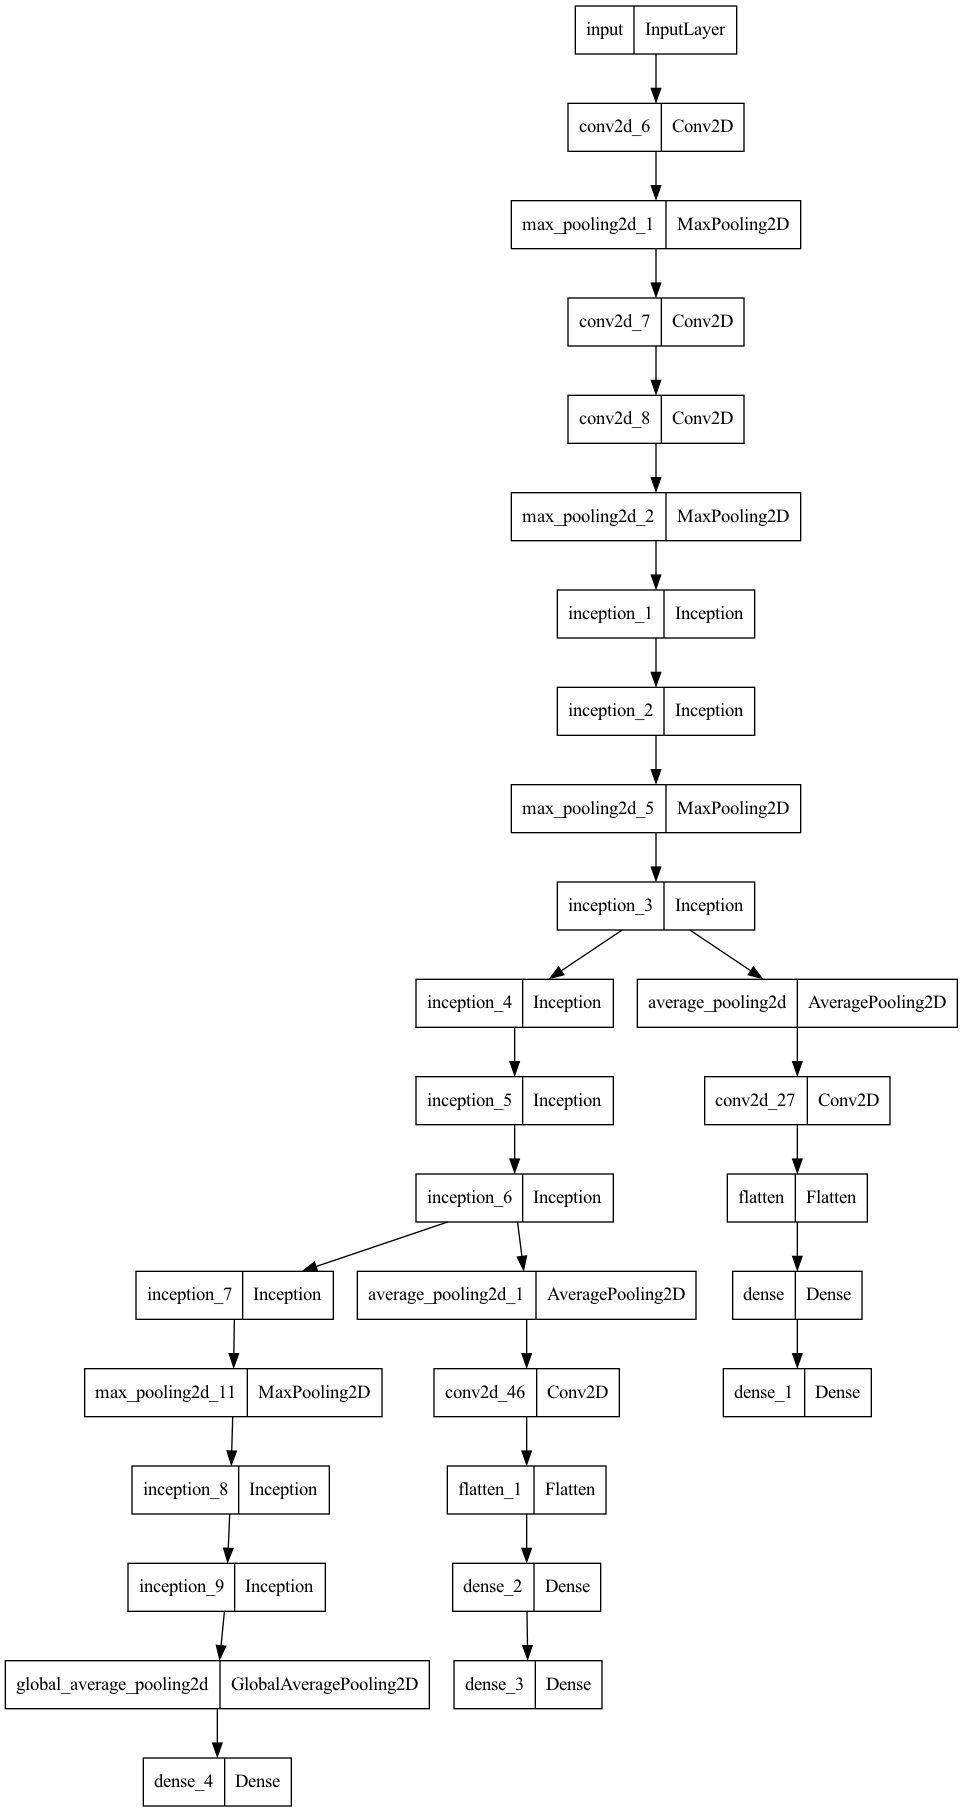

In [9]:
model = tf.keras.Model(inputs=inputs,outputs=[output,aux_output1,aux_output2])
tf.keras.utils.plot_model(model)

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],loss_weights=[1,0.3,0.3])

model.fit(train_images,train_labels,batch_size=128,epochs=3,verbose=1,validation_split=0.1)

Epoch 1/3


2023-04-11 20:24:40.298076: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 9s 4s/step - loss: 4.2343 - dense_4_loss: 2.4724 - dense_1_loss: 3.2530 - dense_3_loss: 2.6200 - dense_4_accuracy: 0.0478 - dense_1_accuracy: 0.1174 - dense_3_accuracy: 0.1174 - val_loss: 3.8301 - val_dense_4_loss: 2.3131 - val_dense_1_loss: 2.7354 - val_dense_3_loss: 2.3212 - val_dense_4_accuracy: 0.0769 - val_dense_1_accuracy: 0.1154 - val_dense_3_accuracy: 0.1154
Epoch 2/3
2/2 [==============================] - 7s 3s/step - loss: 3.6927 - dense_4_loss: 2.2836 - dense_1_loss: 2.4264 - dense_3_loss: 2.2705 - dense_4_accuracy: 0.1391 - dense_1_accuracy: 0.1565 - dense_3_accuracy: 0.1391 - val_loss: 3.7119 - val_dense_4_loss: 2.3111 - val_dense_1_loss: 2.3527 - val_dense_3_loss: 2.3166 - val_dense_4_accuracy: 0.0769 - val_dense_1_accuracy: 0.1538 - val_dense_3_accuracy: 0.0769
Epoch 3/3
2/2 [==============================] - 6s 3s/step - loss: 3.6299 - dense_4_loss: 2.2825 - dense_1_loss: 2.2298 - dense_3_loss: 2.2616 - dense_4_accuracy: 0.1391 - d

In [13]:
model.evaluate(test_images,test_labels)

4/4 [==============================] - 1s 228ms/step - loss: 3.5923 - dense_4_loss: 2.2711 - dense_1_loss: 2.1685 - dense_3_loss: 2.2353 - dense_4_accuracy: 0.1406 - dense_1_accuracy: 0.2344 - dense_3_accuracy: 0.1406


[3.5922770500183105,
 2.2711338996887207,
 2.1684927940368652,
 2.2353172302246094,
 0.140625,
 0.234375,
 0.140625]